# Working with Time Series Data

In [ ]:
import pandas as pd
import altair as alt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

Throughout this chapter of Time-Series, we will be working with Online Retail II dataset, sourced from the UCI Machine Learning Repository, comprises over one million transactions from a UK-based online giftware retailer spanning from December 2010 to December 2011. This multivariate time-series dataset includes 8 features capturing detailed information.

* Invoice: Unique identifier for each sales transaction.

* StockCode: Unique code representing each product/item.

* Description: Text description of the product/item.

* Quantity: Number of units sold in the transaction.

* Price: Price per unit of the product/item.

* Customer ID: Unique identifier for the customer making the purchase.

* Country: Country where the customer is located.

* InvoiceDate: Date and time when the invoice (transaction) was created.

For now, let's keep it simple and focus on the basic goal of predicting the country’s sales of United Kingdom only for ease of use.

## Loading Time-Series Data with DateTime Indexing

In [ ]:
url = 'https://drive.google.com/uc?id=15zVC47Zy5IPINchVmXO0K8XPPYLp0Y_6'
df_2009_10 = pd.read_csv(url, parse_dates=['InvoiceDate'], index_col='InvoiceDate')

url = 'https://drive.google.com/uc?id=1YYAzMarGKWaG6gnqyzGaUjnaNKm0wwNP'
df_2010_11 = pd.read_csv(url, parse_dates=['InvoiceDate'], index_col='InvoiceDate')

/tmp/ipython-input-2-1701371761.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2009_10 = pd.read_csv(url, parse_dates=['InvoiceDate'], index_col='InvoiceDate')


* **parse_dates=['InvoiceDate']** tells pandas to convert the InvoiceDate column into proper datetime format

* **index_col='InvoiceDate'** sets it as the DataFrame index.

This setup makes time-based analysis easier and **more efficient, allowing quick filtering, grouping, and resampling by date.** Although it may slightly slow down the initial file loading, it significantly improves the speed and simplicity of time-series operations later.

In [ ]:
df_store_data = pd.concat([df_2009_10, df_2010_11])

Here we are concating the dataset of 2009 to 2011 into single df

In [ ]:
df_store_data.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country
InvoiceDate,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom


In [ ]:
# Now get min and max dates from the index
min_date = df_store_data.index.min()
max_date = df_store_data.index.max()


print("Min InvoiceDate:", min_date)
print("Max InvoiceDate:", max_date)

Min InvoiceDate: 2009-12-01 07:45:00
Max InvoiceDate: 2011-12-09 12:50:00


In [ ]:
print(type(df_store_data.index))  # Checking whether the InvoiceDate column is in DateTime Format or not

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
# converting df coumns to lowercase & in proper format for sanity

df_store_data.columns = df_store_data.columns.str.strip().str.lower().str.replace(' ', '_')
df_store_data.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'price',
       'customer_id', 'country'],
      dtype='object')

In [ ]:
# Filtering DataFrame to keep only rows where country is 'United Kingdom' for ease of use
# Also, we will only be predicting sales for UK

df_store_data = df_store_data[df_store_data['country'] == 'United Kingdom']

## Handling Missing Values

Missing Values, how to handle

1. **Placeholder Values:** Replacing missing data with placeholder values like 0, -999, or np.inf can flag missingness, but it risks introducing bias if not handled carefully.

2. **Use Statistical Imputation (e.g., Mean):** Filling missing values with the column mean is simple, but it may distort the data distribution and reduce variance.

3. **Last Observed Value (Forward Fill):** Carrying forward the last known value is useful for time-series data but assumes that recent trends persist, which may not always be valid.

4. **Interpolation:** It estimates missing values based on neighboring data points, offering a smoother and often more accurate fill—especially for continuous data using different method (Eg. Liner, Polynomial Nearest, Neighbor etc) . It predicts missing values by assuming a smooth change between known points, drawing a straight line between the nearest known values before and after the gap, then calculating the missing values proportionally along that line.

**Importance of not handling missing vlaues in Time Series:**

In time-series, removing rows with missing data (e.g., via dropna()) can:

* **Break temporal continuity:** Time-series models rely on evenly spaced data.

* **Distort trend analysis:** Gaps in time can confuse rolling averages, differencing, seasonal decomposition, etc.

* **Cause leakage or misleading patterns:** Models might incorrectly interpret the data gaps as changes in behavior.

Use `dropna()` only if **the number of missing rows is small**, **the missing data isn't crucial for maintaining time-based continuity**, or **the time index can be accurately rebuilt without affecting downstream analysis**.


In [ ]:
df_store_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 981330 entries, 2009-12-01 07:45:00 to 2011-12-09 12:49:00
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   invoice      981330 non-null  object 
 1   stockcode    981330 non-null  object 
 2   description  976948 non-null  object 
 3   quantity     981330 non-null  int64  
 4   price        981330 non-null  float64
 5   customer_id  741301 non-null  float64
 6   country      981330 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 59.9+ MB


In [ ]:
df_store_data.describe()

,quantity,price,customer_id
count,981330.000000,981330.000000,741301.000000
mean,8.858259,4.537892,15554.046300
std,172.638944,126.743401,1594.076188
min,-80995.000000,-53594.360000,12346.000000
25%,1.000000,1.250000,14203.000000
50%,3.000000,2.100000,15551.000000
75%,10.000000,4.150000,16936.000000
max,80995.000000,38970.000000,18287.000000


In [ ]:
print("Total number of Null Values: ", df_store_data.isna().sum())

Total number of Null Values:  invoice             0
stockcode           0
description      4382
quantity            0
price               0
customer_id    240029
country             0
dtype: int64


The **`Description`** column is not particularly important in our case since we won’t be performing any NLP tasks. However, if needed, we can handle it similarly to how we’ve treated the **`Price`** column—for example, by addressing missing values or formatting issues appropriately.


#### Handling Null Customer Id's - Place Holder

In [ ]:
df_store_data[df_store_data['customer_id'].isnull()].head()

,invoice,stockcode,description,quantity,price,customer_id,country
InvoiceDate,,,,,,,
2009-12-01 10:52:00,489464,21733,85123a mixed,-96,0.00,NaN,United Kingdom
2009-12-01 10:52:00,489463,71477,short,-240,0.00,NaN,United Kingdom
2009-12-01 10:53:00,489467,85123A,21733 mixed,-192,0.00,NaN,United Kingdom
2009-12-01 11:44:00,489521,21646,NaN,-50,0.00,NaN,United Kingdom
2009-12-01 11:49:00,489525,85226C,BLUE PULL BACK RACING CAR,1,0.55,NaN,United Kingdom


In [ ]:
df_store_data['customer_id'] = df_store_data['customer_id'].fillna('000000')


We use a placeholder Customer ID of 000000 for valid transactions made by anonymous users. This allows us to group all such transactions under a single identifier while preserving the validity of the data.

In [ ]:
print(df_store_data['customer_id'].isnull().sum())

0


#### Handling Zero or Negative Values price Columns : Forward Fill


In [ ]:
df_store_data.loc[df_store_data['price'] <= 0, 'price'] = np.nan

df_store_data['price'] = df_store_data.groupby('stockcode')['price'].ffill()

Since the price for a given stockcode remains consistent, we fill missing or zero prices by carrying forward the most recent known price within the same stockcode group. This ensures that for each stockcode, any missing or zero price is replaced with the last valid price observed in that group.

In [ ]:
# Compute 'TotalSales' as quantity * price since we will be predicting this later
df_store_data['total_sales'] = df_store_data['quantity'] * df_store_data['price']

In [ ]:
df_store_data.head()

,invoice,stockcode,description,quantity,price,customer_id,country,total_sales
InvoiceDate,,,,,,,,
2009-12-01 07:45:00,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,6.95,13085.0,United Kingdom,83.4
2009-12-01 07:45:00,489434,79323P,PINK CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,81.0
2009-12-01 07:45:00,489434,79323W,WHITE CHERRY LIGHTS,12,6.75,13085.0,United Kingdom,81.0
2009-12-01 07:45:00,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2.10,13085.0,United Kingdom,100.8
2009-12-01 07:45:00,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,1.25,13085.0,United Kingdom,30.0


### Resampling

**Data resampling** is a technique used to adjust the number or frequency of data points while preserving key patterns. It's commonly used in time series to change data frequency and in machine learning to handle class imbalance or evaluate models.

Resampling involves changing the frequency of your time series observations.

1. **Upsampling:** Increasing the frequency (e.g., from daily to hourly data), which may require interpolation to fill in missing values.

2. **Downsampling:** Reducing the frequency (e.g., from daily to monthly), which involves aggregation (e.g., using mean, sum, max).

Here, rather than aggregating all data into a single summary, we can generate separate DataFrames tailored to **specific analyses, such as by product (`StockCode`) or country.**


In [ ]:
# Monthly summary (downsampled)
# Downsampling the data From minutes to daily

df = (
    df_store_data
    .resample('D')  #  Resample data into daily intervals based on the DateTime index ('InvoiceDate')
    .agg(           #  Aggregate using the following logic:
        total_transaction = ('invoice', 'nunique'),     # Count of unique invoices per hour → total transactions
        total_quantity = ('quantity', 'sum'),       # Sum of items sold per hour → total quantity
        total_sales = ('total_sales', 'sum')              # Sum of sales amount per hour
    )
    .reset_index()  # Reset index to convert the datetime index back into a regular column
)

df.rename(columns={'InvoiceDate': 'invoice_date'}, inplace=True) # Renaming columns for more appropriate names as wellm as better readability and understanding.
df['invoice_date'] = pd.to_datetime(df['invoice_date']) # Converting to datetime format
df = df.set_index('invoice_date') # Set it as the index
df = df.sort_index() # Sort by the new index


df.head()

,total_transaction,total_quantity,total_sales
invoice_date,,,
2009-12-01,154,20736,45958.31
2009-12-02,125,25657,54826.26
2009-12-03,144,44557,57521.87
2009-12-04,100,19550,37222.23
2009-12-05,31,4636,8803.86


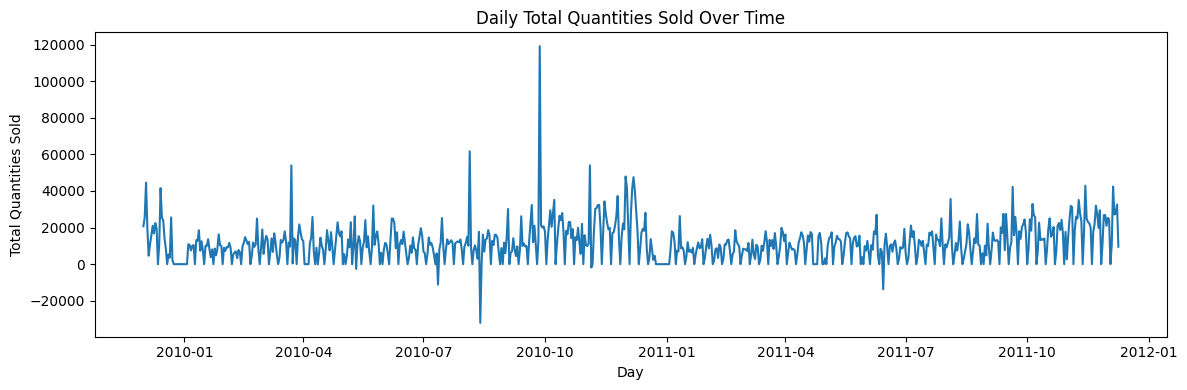

In [ ]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df, x='invoice_date', y='total_quantity')
plt.title('Daily Total Quantities Sold Over Time')
plt.xlabel('Day')
plt.ylabel('Total Quantities Sold')
plt.tight_layout()
plt.show()


Here we could see that some of the days have negative quantities sold. It might be due to returns or data entry error. For this chapter, we will just clip the total_quantity to 0, so that there are no negatives.

In [ ]:
df['total_quantity'] = df['total_quantity'].clip(lower=0)

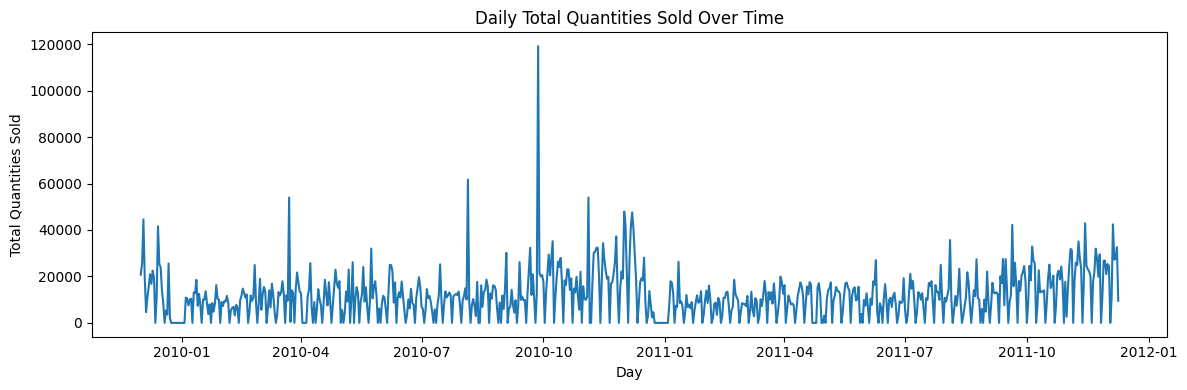

In [ ]:
plt.figure(figsize=(12, 4))
sns.lineplot(data=df, x='invoice_date', y='total_quantity')
plt.title('Daily Total Quantities Sold Over Time')
plt.xlabel('Day')
plt.ylabel('Total Quantities Sold')
plt.tight_layout()
plt.show()


We can see in the data, that there are several 0 values and two flat lines during the end of the years. Upon investigation, we found out that the stores are always closed on weekends and on December holiday period.

These type of scenarios are often met when we are working with real-world datasets. How these are handled depends upon the problem we are working on. For this chapter, we will be leaving those zeroes and expect the model to learn thise pattern. For some models, we can include features like '**is_weekend**' or '**is_holiday**' to make it easier for the model.

## Stationarity

A stationary time series is one **whose statistical properties do not change over time**. This means:

* Constant mean

* Constant variance

* Constant autocovariance (i.e., correlation between terms at different lags is constant over time)

It is relevent in Time Series forexasting because models like ARIMA and SARIMA assume stationarity because it ensures consistent statistical properties, making patterns more stable and predictions more reliable.

There are many test for cheking stationarity such as Phillips-Perron (PP) Test, Zivot-Andrews Test, Ljung-Box Test, Variance Ratio Test which is beyond the scope of this notebook so **we will only be focusing on the Augmented Dickey-Fuller Test**.

#### Augmented Dickey-Fuller (ADF)- Checking Stationarity

**Augmented Dickey-Fuller (ADF)** test is a statistical test used to check stationarity in a time series, specifically whether a unit root is present (which indicates non-stationarity).

The Equation for ADF is given as:

$$
\Delta y_t = \alpha + \beta t + \gamma y_{t-1} + \sum_{i=1}^{p} \delta_i \Delta y_{t-i} + \epsilon_t
$$

Where:

$$
\begin{aligned}
\Delta y_t &= y_t - y_{t-1} && \text{: First difference (to remove trends)} \\
y_{t-1} &&& \text{: Lagged level of the series} \\
\delta_i &&& \text{: Coefficients on lagged first differences (to account for autocorrelation)} \\
\alpha &&& \text{: Constant (optional)} \\
\beta t &&& \text{: Time trend (optional)} \\
\end{aligned}
$$


The test stastic formula is:
$$
t_{\gamma} = \frac{\hat{\gamma}}{\mathrm{Squared Error}(\hat{\gamma})}
$$

**Assumptions**

The test is conducted under following assumptions:

1. Null Hypothesis (H0): There exists a unit root in the time series and it is non-stationary. Unit root = 1 or δ = 0
2. Alternate Hypothesis (H1): There exists no unit root in the time series and it is stationary. Unit root < 1 or δ < 0

**Condition to reject H0 and accept H1**

To say that a time series is stationary, we need to reject the null hypothesis (which assumes the series is non-stationary). Here's how we decide:

1. Look at the ADF test statistic and compare it with the critical value:

  * If the **test statistic is smaller** (more negative) than the critical value (e.g., at the 5% level), then we **reject H₀ → the series is stationary.**

  * If it's **greater** (less negative), **then we fail to reject H₀ → the series is non-stationary.**

2. Check the p-value:

  * If then **p-value is less than 0.05** (or whatever significance level you're using), **reject H₀ → the series is stationary.**

  * If the **p-value is large** (e.g., greater than 0.05), **we fail to reject H₀ → the series is non-stationary.**

> The critical values come from special tables made for the Dickey-Fuller test (kind of like how we use t-tables in t-tests).




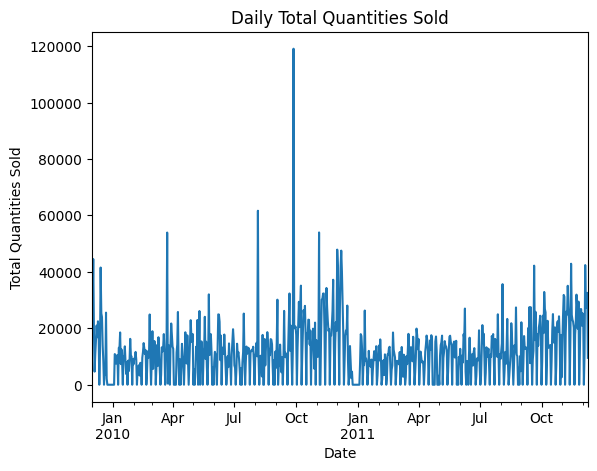

ADF Statistic: -2.9292554289280095
p-value: 0.04205022800442057
Critical Values:
   1%: -3.439490435810785
   5%: -2.8655738086413374
   10%: -2.568918067209286
Reject null hypothesis → Series is stationary.


In [ ]:
daily_qty = df['total_quantity']

# Plot to visually inspect
daily_qty.plot(title='Daily Total Quantities Sold')
plt.xlabel("Date")
plt.ylabel("Total Quantities Sold")
plt.show()

# ADF Test
adf_result = adfuller(daily_qty.dropna())

# Print ADF result
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if adf_result[1] < 0.05:
    print("Reject null hypothesis → Series is stationary.")
else:
    print("Fail to reject null hypothesis → Series is non-stationary.")

Here, we **reject the null hypothesis** because the p-value (0.042) is less than the common threshold of 0.05. This provides strong evidence that the **time series is stationary**, meaning its statistical properties like mean and variance remain constant over time.

As the dataset is stationary, **we will use it in the upcoming chapters**. Nonetheless, to deepen our understanding of various techniques, we will also apply alternative methods on how to convert a non-stationary series to a stationary one for educational purposes.

In [ ]:
df_to_use = df.copy()

### Stationarity techniques

These methods are essential for improving model performance by ensuring the data’s statistical properties remain consistent over time. While stationarity helps with model assumptions, transforming data to follow a normal distribution may require additional techniques such as data transformation.

#### Transforming



 1. Transforming

  **Transforming** means applying a mathematical function to data to change its scale, distribution, or behavior — often to make it more suitable for analysis or modeling. It makes the **trend more linear and the variance stabilized.**

  * Log Transformation (typicall done for right skewed data):
    $$
      Y'_t = \log(Y_t)
    $$

  * Power Transformations

      1. Square Root Transformation
          $$
            Y'_t = \sqrt{Y_t}
          $$
      2. Cube Root Transformation
          $$
          Y'_t = Y_t^{1/3}
          $$
      3. Box-Cox Transformation
      
$$    
Y'_t =
\begin{cases}
\dfrac{Y_t^\lambda - 1}{\lambda}, & \text{if } \lambda \neq 0 \\
\log(Y_t), & \text{if } \lambda = 0
\end{cases}
$$


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


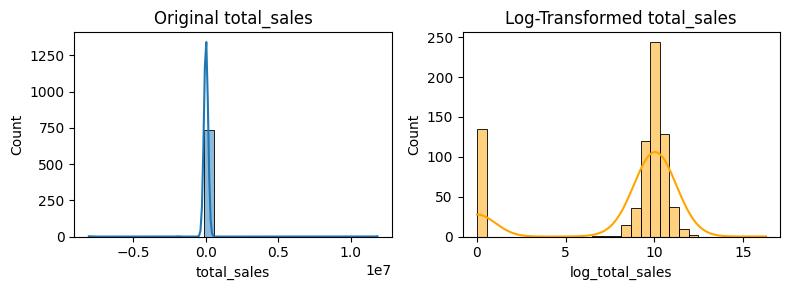

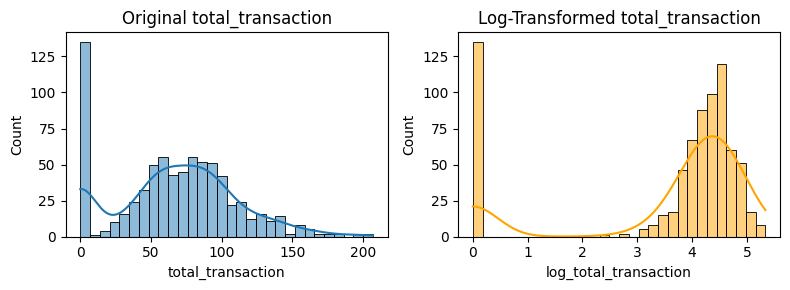

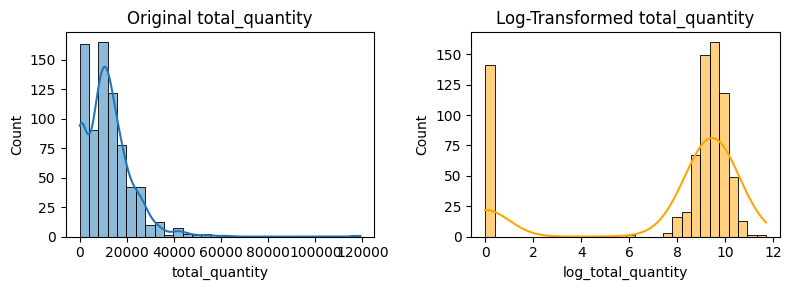

In [ ]:
# Columns to check
cols = ['total_sales', 'total_transaction', 'total_quantity']

# Create new columns for log-transformed data
for col in cols:
    df[f'log_{col}'] = np.log(df[col] + 1)  # Add 1 to avoid log(0)

# Now plot original vs log-transformed columns
for col in cols:
    plt.figure(figsize=(8,3))  # Smaller size

    # Histogram before log transform
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Original {col}')

    # Histogram after log transform from new column
    plt.subplot(1, 2, 2)
    sns.histplot(df[f'log_{col}'], kde=True, bins=30, color='orange')
    plt.title(f'Log-Transformed {col}')

    plt.tight_layout()
    plt.show()

#### 2. Differencing


  
  Subtract the current value from the previous value to remove trends. It **removes trend or seasonality** depending on the order and lag.

  * First-order differencing:
  $$
  Y'_t = Y_t - Y_{t-1}
  $$
  * Second-order differencing:
  $$
  Y''_t = Y'_t - Y'_{t-1}
  $$


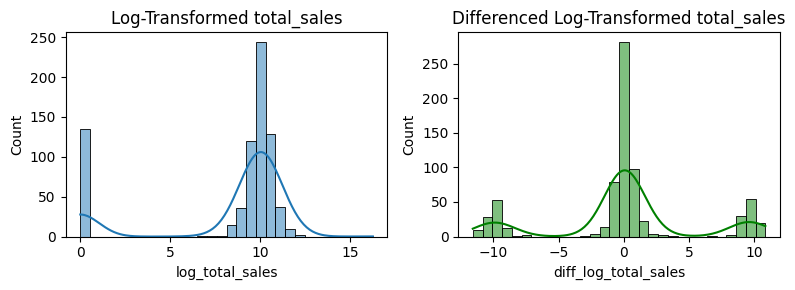

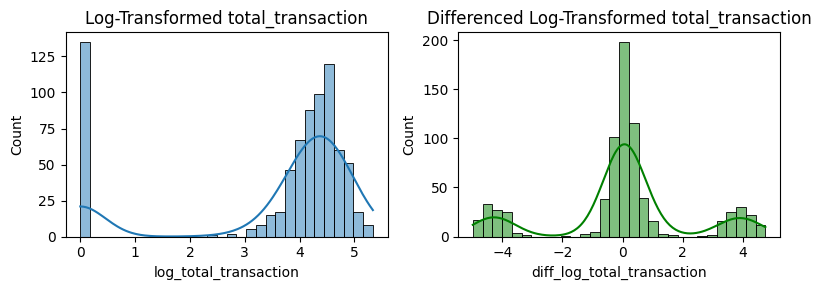

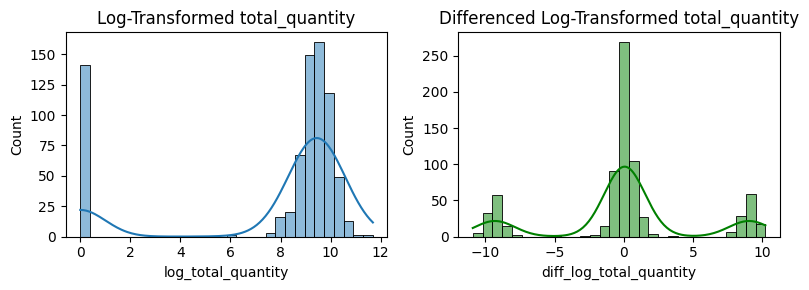

In [ ]:
for col in cols:

    # Create new column for differenced log transform
    df[f'diff_log_{col}'] = df[f'log_{col}'].diff()

    # Plotting
    plt.figure(figsize=(8,3))

    plt.subplot(1, 2, 1)
    sns.histplot(df[f'log_{col}'].dropna(), kde=True, bins=30)
    plt.title(f'Log-Transformed {col}')

    plt.subplot(1, 2, 2)
    sns.histplot(df[f'diff_log_{col}'].dropna(), kde=True, bins=30, color='green')
    plt.title(f'Differenced Log-Transformed {col}')

    plt.tight_layout()
    plt.show()


In [ ]:
df.head()

,total_transaction,total_quantity,total_sales,log_total_sales,log_total_transaction,log_total_quantity,diff_log_total_sales,diff_log_total_transaction,diff_log_total_quantity
invoice_date,,,,,,,,,
2009-12-01,154,20736,45958.31,10.735512,5.043425,9.939675,NaN,NaN,NaN
2009-12-02,125,25657,54826.26,10.911943,4.836282,10.152611,0.176431,-0.207143,0.212936
2009-12-03,144,44557,57521.87,10.959938,4.976734,10.704547,0.047995,0.140452,0.551936
2009-12-04,100,19550,37222.23,10.524688,4.615121,9.880782,-0.435250,-0.361613,-0.823765
2009-12-05,31,4636,8803.86,9.083059,3.465736,8.441823,-1.441629,-1.149385,-1.438959


In [ ]:
daily_qty = df['diff_log_total_quantity']
# ADF Test
adf_result = adfuller(daily_qty.dropna())

# Print ADF result
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

# Interpretation
if adf_result[1] < 0.05:
    print("Reject null hypothesis → Series is stationary.")
else:
    print("Fail to reject null hypothesis → Series is non-stationary.")

ADF Statistic: -8.976115776999807
p-value: 7.524217641498749e-15
Critical Values:
   1%: -3.439503230053971
   5%: -2.8655794463678346
   10%: -2.5689210707289982
Reject null hypothesis → Series is stationary.


While both series (The first one and this) are stationary, the second exhibits a much **larger gap between its test statistic and the critical values (and a far smaller p-value)**, indicating it is the more strongly stationary of the two.

## Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF)

### Auto-Correlation Function (ACF)


The Autocorrelation Function (ACF) is a statistical tool used to measure the **correlation between a time series and its own past (lagged) values.**

* It shows how much past values influence current values.

* ACF at lag k is the correlation between the time series and its values k time steps before.

**Use Cases:**

* Identifying the MA (Moving Average) order in ARIMA models.

* Checking if observations in a time series are independent.

**Example Insight:**
If ACF at lag 1 is high (e.g., 0.8), it means the current value is strongly influenced by the immediate previous value.

<Figure size 1000x400 with 0 Axes>

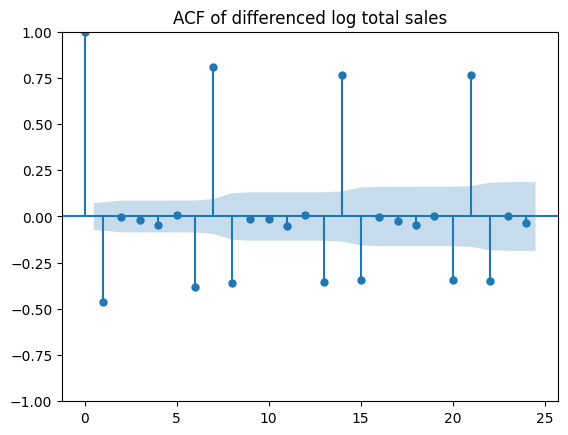

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Drop missing values (NaN in differenced series)
diff_log_total_qty = df['diff_log_total_quantity'].dropna()

# Plot ACF and PACF
plt.figure(figsize=(10, 4))
plot_acf(diff_log_total_qty, lags=24)
plt.title("ACF of differenced log total sales")
plt.show()

Interpreting an ACF Plot:

When analyzing an Autocorrelation Function (ACF) plot, each vertical bar represents the correlation between the time series and a lagged version of itself. Here's what to look for:

* **Significant Lags:** Bars that extend beyond the confidence intervals (the shaded or dotted lines) indicate statistically significant autocorrelation at that lag.

* **Gradual Decline (Tailing Off):** If the bars decrease slowly over several lags, it suggests the presence of long-term dependencies or trends in the data.

* **Seasonal Patterns:** Repeating spikes at regular intervals (e.g., every 12 or 24 lags) point to seasonal or cyclical behavior in the time series.

### Partial Autocorrelation Function (PACF)


The Partial Autocorrelation Function (PACF) **measures the direct correlation between a time series and its lagged values, after removing the effects of intermediate lags.**

It isolates the unique contribution of each lag to the current value.

PACF at lag k shows the correlation between the time series and its k-th lag excluding the influence of lags 1 through k–1.

Use Cases:

* Identifying the AR (Autoregressive) order in ARIMA models.

* Understanding direct lag influence, not just cumulative effects.

* Helps distinguish the true number of significant lag terms to include in an AR model.

**Example Insight:** If PACF at lag 1 is high (e.g., 0.7) but drops sharply afterward, it indicates that only the first lag has a strong direct effect, and further lags are not significant—suggesting an AR(1) model may be appropriate.

<Figure size 1000x400 with 0 Axes>

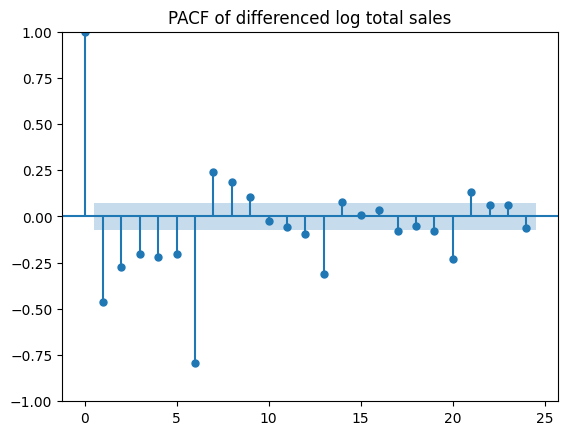

In [ ]:
plt.figure(figsize=(10, 4))
plot_pacf(diff_log_total_qty, lags=24, method='ywm')
plt.title("PACF of differenced log total sales")
plt.show()

Interpreting PACF Plots

The PACF plot is a key tool for identifying the appropriate order of an Autoregressive (AR) model.

* **Significant Spikes:** A prominent spike at a specific lag indicates that the corresponding lagged value has a strong direct relationship with the current value, suggesting it should be included in the AR model.

* **Cut-off Point:** The point where the PACF values drop off to near zero (and remain within the confidence bounds) indicates the highest lag order to consider for the AR model. This helps in selecting the optimal number of lag terms.

In short, the PACF plot helps you decide how many past values (lags) to include in your AR model based on their direct impact on the current observation.

## Time-series Decomposition

Time-Series Decomposition is a technique used to **break down a time series into its individual components** to better understand the underlying patterns.

**Components of Decomposition:**

1. Trend

  * The long-term progression of the series (upward, downward, or flat).

  * Shows the general direction over a long period.

2. Seasonality

  * Repeating short-term cycle in the data (daily, weekly, monthly, etc.).

  * Occurs at regular intervals due to seasonal effects like weather, holidays, etc.

3. Residual (or Noise)

  * The random variation or irregular component that cannot be explained by trend or seasonality.

  * Reflects unpredictable, non-systematic influences.


**Two Types of Decomposition:**

1. Additive Model

  * **Assumes:**

    Time Series = Trend + Seasonality + Residual

    Used when seasonal variation is roughly constant over time.

2. Multiplicative Model

  * **Assumes:**
  
    Time Series = Trend × Seasonality × Residual

    Used when seasonal variation increases or decreases with the trend.

Use Cases:

* Makes it easier to analyze and forecast time series data.

* Helps in removing seasonality and trend to build more accurate predictive models.

* Provides insight into the structure and behavior of your data.


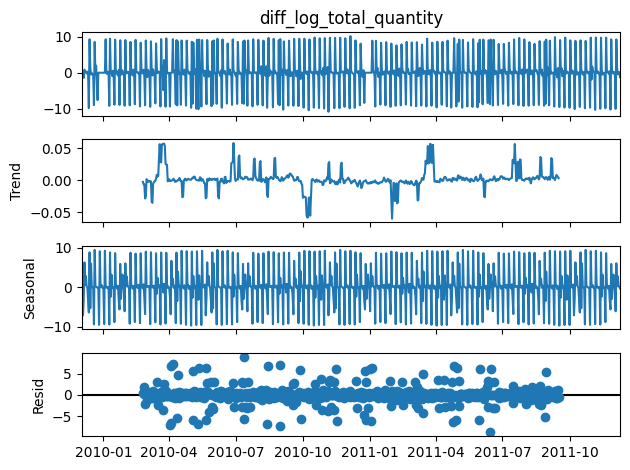

In [ ]:
# Use one column and drop NaNs
ts = df['diff_log_total_quantity'].dropna()

# Decompose
decomposition = seasonal_decompose(ts, model='additive', period=168)

# Plot
decomposition.plot()
plt.tight_layout()
plt.show()


The time series contains a clear trend, strong seasonal components, and reasonably random residuals.

The decomposition is successful and appropriate, making this a good base for further modeling like ARIMA, SARIMA, or forecasting.

## Saving for Future Use in Other Notebooks

The df_to_use dataset was created earlier in the 'Stationarity Techniques' section.

In [ ]:
df_to_use.head()

,total_transaction,total_quantity,total_sales
invoice_date,,,
2009-12-01,154,20736,45958.31
2009-12-02,125,25657,54826.26
2009-12-03,144,44557,57521.87
2009-12-04,100,19550,37222.23
2009-12-05,31,4636,8803.86


In [ ]:
df_to_use.to_csv('cleaned_data.csv')

We have retained and saved the cleaned dataset here, which will be used in future chapters.